# **EDA Questions**


1.   What do basket size distributions look like
2.   How frequently is each item bought?
3.   What items are bought the most/least frequently
5.   Basket composition clustering



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

In [18]:
"""
read in data that was previously cleaned
1. cats = categories of each item (manually created)
2. transactions_df = cleaned transaction data (seperate col for each item)
3. transactions = each transaction represented by a series
"""
cats = pd.read_csv("categories - test.csv")
transactions_df = pd.read_csv("grocery_transactions_clean.csv")
transactions = pd.read_pickle("transactions_clean.pkl")

# Basket Distribution

In [22]:
# check distribution of items in a basket
basket_counts = transactions.apply(len)
print(basket_counts.describe())

count    7011.000000
mean        5.649265
std         3.548252
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        32.000000
dtype: float64


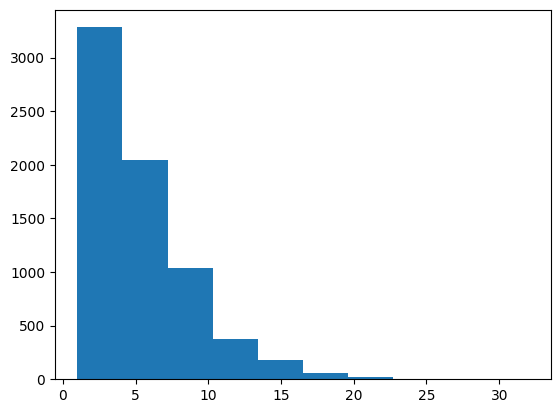

In [23]:
plt.hist(basket_counts)
plt.show()

Basket size is mainly between 1-5 items. Basket sizes seem to be on the smaller end

# Item Frequency

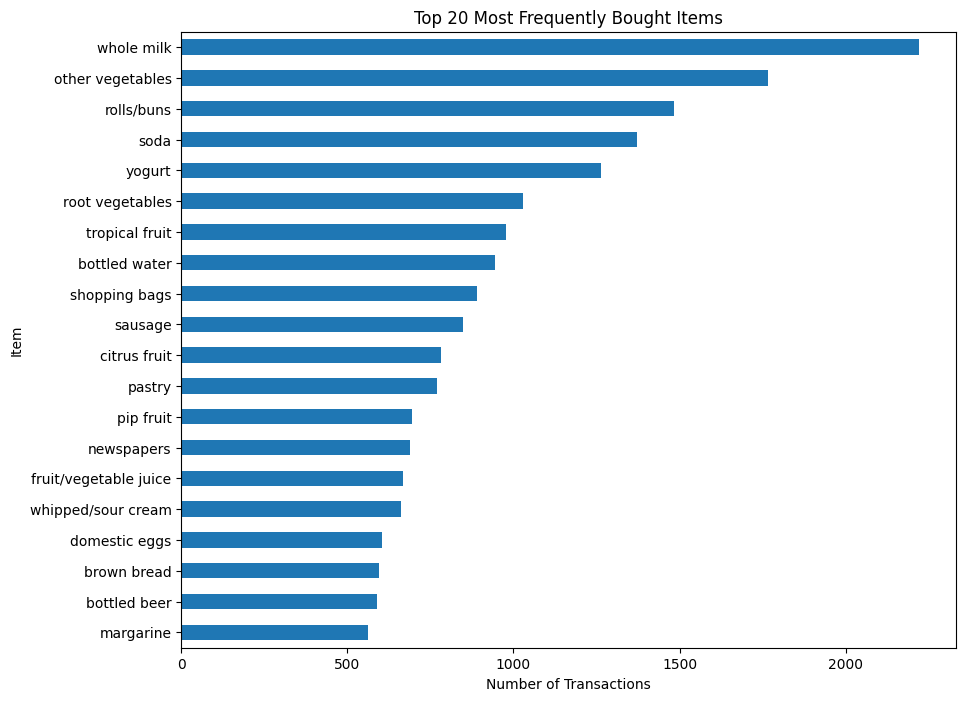

In [24]:
all_items = [item for transaction in transactions for item in transaction]

item_counts = pd.Series(all_items).value_counts()

item_counts.head(20).plot(kind='barh', figsize=(10,8))
plt.xlabel("Number of Transactions")
plt.ylabel("Item")
plt.title("Top 20 Most Frequently Bought Items")
plt.gca().invert_yaxis()  # Largest on top
plt.show()



Basic pantry stables seem to be the most purchased (ex: fruit, vegetable, milk, eggs)

# Item Pairings

Gives the highest occurance of 2 and 3 itmes together. While this may not prove one item leads to another being bought, it can give an idea of what is to be expected in the next analysis

In [46]:
# formats data for counting
item_cols = transactions_df.columns
item_cols = item_cols.drop(["Item(s)", "count_matches"])

transactions_df['items'] = (transactions_df[item_cols].apply(lambda row: row.dropna().astype(str).str.strip().str.lower().tolist(), axis=1))


In [80]:
pair_counter = Counter()

for items in transactions_df['items']:
    pair_counter.update(combinations(sorted(items), 2))

pair_counter.most_common(10)

[(('other vegetables', 'whole milk'), 726),
 (('whole milk', 'yogurt'), 539),
 (('rolls/buns', 'whole milk'), 532),
 (('root vegetables', 'whole milk'), 478),
 (('other vegetables', 'root vegetables'), 459),
 (('other vegetables', 'yogurt'), 419),
 (('other vegetables', 'rolls/buns'), 410),
 (('tropical fruit', 'whole milk'), 407),
 (('soda', 'whole milk'), 387),
 (('other vegetables', 'tropical fruit'), 347)]

In [50]:
triplet_counter = Counter()

for items in transactions_df['items']:
    triplet_counter.update(combinations(sorted(items), 3))

triplet_counter.most_common(10)

[(('other vegetables', 'root vegetables', 'whole milk'), 228),
 (('other vegetables', 'whole milk', 'yogurt'), 218),
 (('other vegetables', 'rolls/buns', 'whole milk'), 176),
 (('other vegetables', 'tropical fruit', 'whole milk'), 168),
 (('rolls/buns', 'whole milk', 'yogurt'), 153),
 (('tropical fruit', 'whole milk', 'yogurt'), 148),
 (('other vegetables', 'whipped/sour cream', 'whole milk'), 143),
 (('root vegetables', 'whole milk', 'yogurt'), 143),
 (('other vegetables', 'soda', 'whole milk'), 137),
 (('other vegetables', 'pip fruit', 'whole milk'), 133)]

# Basket Composition Clustering

In [82]:
# adds category labels to each item
item_to_cat = dict(zip(cats['item'], cats['Category']))
cats['item'] = cats['item'].str.strip().str.lower()
transactions_df['items'] = transactions_df['items'].apply(lambda x: [i.strip().lower() for i in x])
transactions_df['categories'] = transactions_df['items'].apply(lambda items: [item_to_cat.get(i, 'unknown') for i in items])
transactions_df['categories'] = transactions_df['items'].apply(lambda items: [item_to_cat.get(i, 'unknown') for i in items])
transactions_df['category_counts'] = transactions_df['categories'].apply(Counter)

In [64]:
# finds the count of categories in each basket
transactions_df = transactions_df.reset_index(drop=True)
transactions_df['transaction_id'] = transactions_df.index
cat_counts_df = (transactions_df.explode('categories').groupby(['transaction_id', 'categories']).size().unstack(fill_value=0))


In [66]:
cat_counts_df.head()

categories,alcoholic beverages,baby,bakery,baking/cooking,beverages,breakfast,candy,cleaning product,condiments,cosmetics/first aid,dairy,fruit/vegetables,houseware,meat,other,pets,ready made meals,snacks
transaction_id,,,,,,,,,,,,,,,,,,
0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [68]:
cat_counts_df.mean().sort_values(ascending=False)

,0
categories,
dairy,1.112965
fruit/vegetables,1.010697
meat,0.582228
beverages,0.580659
bakery,0.551419
baking/cooking,0.324490
houseware,0.265725
snacks,0.264156
alcoholic beverages,0.235059


Shows the most common categories to be purchased

In [84]:
cat_counts_df.corr()

categories,alcoholic beverages,baby,bakery,baking/cooking,beverages,breakfast,candy,cleaning product,condiments,cosmetics/first aid,dairy,fruit/vegetables,houseware,meat,other,pets,ready made meals,snacks
categories,,,,,,,,,,,,,,,,,,
alcoholic beverages,1.000000,0.003119,-0.033520,-0.008904,0.086825,-0.015963,0.000369,-0.011735,-0.007582,0.010748,-0.105605,-0.046268,0.048342,-0.028709,-0.022182,-0.011830,-0.024482,-0.037606
baby,0.003119,1.000000,0.026013,0.019027,-0.000383,0.046851,0.021484,0.020989,0.011960,-0.008823,0.030499,0.011306,0.019095,-0.000423,-0.013402,-0.007589,0.043445,0.042949
bakery,-0.033520,0.026013,1.000000,0.052553,0.064919,0.081105,0.085992,0.016002,0.049766,0.028827,0.175036,0.115762,0.054383,0.174639,0.033585,0.004006,0.050657,0.049743
baking/cooking,-0.008904,0.019027,0.052553,1.000000,0.055806,0.040623,0.025328,0.080133,0.092431,0.092675,0.205806,0.189358,0.041109,0.144847,0.021055,0.054208,0.042996,0.027667
beverages,0.086825,-0.000383,0.064919,0.055806,1.000000,0.029645,0.077530,0.009915,0.044126,0.047403,0.090908,0.079405,0.071497,0.018715,0.017319,0.042228,0.032854,0.080082
breakfast,-0.015963,0.046851,0.081105,0.040623,0.029645,1.000000,0.102884,0.027238,0.034141,0.034507,0.077644,0.043652,0.040339,0.041749,0.012619,0.033973,0.044325,0.083219
candy,0.000369,0.021484,0.085992,0.025328,0.077530,0.102884,1.000000,0.030137,0.059689,0.038655,0.043224,0.031859,0.052481,0.030480,0.007349,0.030347,0.028043,0.081674
cleaning product,-0.011735,0.020989,0.016002,0.080133,0.009915,0.027238,0.030137,1.000000,0.047306,0.073184,0.084771,0.079844,0.084523,0.068872,0.033255,0.037741,0.021997,0.020886
condiments,-0.007582,0.011960,0.049766,0.092431,0.044126,0.034141,0.059689,0.047306,1.000000,0.049910,0.092685,0.097556,0.047219,0.109471,0.022801,0.023661,0.029934,0.033794


Shows the correlation between each category being purchased. Again, this does not prove that categories are likely to be purchased together, but it does give a basis to be expected. For example, candy and snacks have a (relatively) high correlation, which could indicate that people who snack a lot, also have a sweet tooth. But, categories like meat and vegetables also have a high correlation which does not help as much because they are both weekly staples of many people